In [1]:
import numpy as np
import deepxde as dde
from scipy.integrate import odeint
from matplotlib import pyplot as plt
import torch

device = 'cuda'
np.random.seed(123)
plt.style.use("bmh")

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
m = 1
c = 1
k = 10

def force(t):
    if isinstance(t, torch.Tensor):
        exp = torch.exp
        sin = torch.sin
    else:
        exp = np.exp
        sin = np.sin
    return (
        exp(-t)
    )

def ddt(u, t):
    y   = u[0]
    y_t = u[1]
    return np.array([
        y_t,
        (
            force(t)
            -
            c * y_t
            -
            k * y
        ) / m
    ])

u0      = np.array([ 0, 0 ])
t       = np.linspace(0, 4 * np.pi, 100)
u, dudt = odeint(ddt, u0, t).T

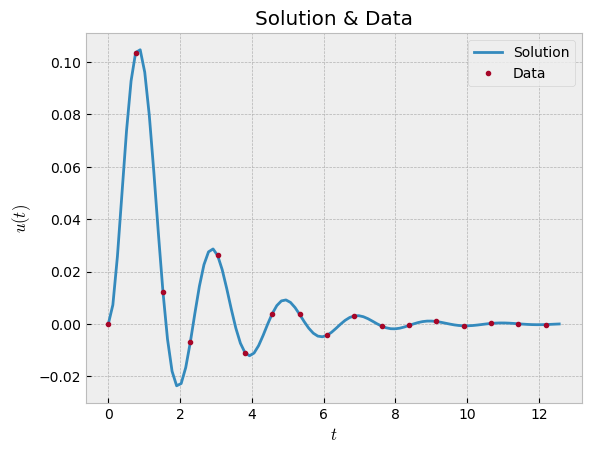

In [3]:
N_POINTS = 15
indices  = np.arange(0, len(t), int(len(t)/N_POINTS))

tdata = t[indices]
udata = u[indices]

plt.figure()
plt.title("Solution & Data")
plt.xlabel(r"$t$")
plt.ylabel(r"$u(t)$")
plt.plot(t, u, label="Solution")
plt.plot(tdata, udata, label="Data", linestyle="None", marker=".")
plt.legend()
plt.show()

In [8]:
geometry = dde.geometry.TimeDomain(t[0], t[-1])
c = dde.Variable(1.0)
k = dde.Variable(1.0)

def ode(t, u):
    y    = u
    y_t  = dde.grad.jacobian(u, t)
    y_tt = dde.grad.hessian(u, t)
    
    residual = (
        force(t)
        -
        m * y_tt
        -
        c * y_t
        -
        k * y
    )
    print(residual.shape)
    return residual

bc = dde.icbc.boundary_conditions.PointSetBC(tdata.reshape(-1,1), udata.reshape(-1,1))

data = dde.data.PDE(
    geometry     = geometry,
    pde          = ode,
    bcs          = [bc],
    num_domain   = 1000,
    num_boundary = 2,
    num_test     = 5
)

net = dde.nn.FNN(
    layer_sizes        = [1] + 10*[32] + [1],
    activation         = "tanh",
    kernel_initializer = "Glorot uniform"
)

model = dde.Model(data, net)
model.compile("adam", lr=1e-4, external_trainable_variables=[c, k])

variable = dde.callbacks.VariableValue(
  [c, k], period=1000, filename="variables.dat"
)

losshistory, train_state = model.train(iterations=800000, callbacks=[variable])

Compiling model...
'compile' took 0.001743 s

Training model...

torch.Size([1019, 1])
torch.Size([22, 1])
0         [3.88e-02, 2.31e-03]    [4.84e-03, 2.31e-03]    []  
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019, 1])
torch.Size([1019

KeyboardInterrupt: 

In [ ]:
model.save("model")

In [ ]:
up = model.predict(t.reshape(-1, 1))
plt.figure()
plt.title("layer_sizes = [1] + 10*[32] + [1]")
plt.xlabel(r"$t$")
plt.ylabel(r"$u(t)$")
plt.plot(t, up, label="Prediction", color="black")
plt.plot(t, u, label="Solution", color="gray")
plt.plot(tdata, udata, linestyle="None", marker="x", label="Collocation Points")
plt.legend()
plt.savefig("1_10x32_1-layers")